In [ ]:
#Google colab was used and results were ran again on 5 July to retrieve the pkl files for submission as supporting docs. 

In [1]:
!pip install gensim
!pip install optuna
!pip install evaluate
!pip install numpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import joblib
from xgboost import XGBClassifier

## XGB Experiments

In [3]:
random.seed(42)
np.random.seed(42)

- Load the train and test files

In [5]:
train_df = pd.read_csv("/content/drive/My Drive/AMLProject/train_data.csv")
val_df  = pd.read_csv("/content/drive/My Drive/AMLProject/val_data.csv")
test_df  = pd.read_csv("/content/drive/My Drive/AMLProject/test_data.csv")

In [6]:
print(f"Train: {len(train_df):>6} rows")
print(f" Val : {len(val_df):>6} rows")
print(f" Test: {len(test_df):>6} rows")

Train:   8000 rows
 Val :   1000 rows
 Test:   1000 rows


## DistilBERT - Experiment 1 (Pretrained Model)

Reference: https://www.byteplus.com/en/topic/496887?title=distilbert-get-embeddings-a-complete-guide

In [7]:
import torch
from transformers import AutoTokenizer, DistilBertModel
from sklearn.metrics import classification_report
import joblib

In [8]:
cuda_available = torch.cuda.is_available()
mps_available  = getattr(torch.backends.mps, "is_available", lambda: False)()

if cuda_available:
    device = "cuda"
elif mps_available:
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: cuda


- Extracting embeddings using pretrained DistilBERT

In [9]:
train_texts = train_df["text"].tolist()
val_texts   = val_df  ["text"].tolist()
y_train     = train_df["sentiment_id"].values
y_val       = val_df  ["sentiment_id"].values

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [11]:
def get_embeddings(texts, batch_size=32):
    all_embeds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size] #slice text into chunks
        enc = tokenizer(
            batch,
            padding="longest",
            truncation=True,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            last_hidden = model(**enc).last_hidden_state
        mask   = enc.attention_mask.unsqueeze(-1)      #mask mean pooling step to convert embeddings into single fixed length vector
        summed = (last_hidden * mask).sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1e-9)
        mean_pooled = summed / counts               #mean pooled is the average embedding per review
        all_embeds.append(mean_pooled.cpu().numpy())
    return np.vstack(all_embeds)


In [12]:
# Compute embeddings for train
X_train_embeds = get_embeddings(train_texts, batch_size=32)
print("Train embeddings shape:", X_train_embeds.shape)
joblib.dump(X_train_embeds, "X_train_embeds_distilbert_experiment1.pkl")

Train embeddings shape: (8000, 768)


['X_train_embeds_distilbert_experiment1.pkl']

In [13]:
import joblib
joblib.dump(X_train_embeds, "X_train_embeds_distilbert_experiment1.pkl")

['X_train_embeds_distilbert_experiment1.pkl']

In [15]:
# Compute embeddings for  validation
X_val_embeds   = get_embeddings(val_texts,   batch_size=32)
print("Validation embeddings shape:", X_val_embeds.shape)
joblib.dump(X_val_embeds,   "X_val_embeds_distilbert_experiment1.pkl")

Validation embeddings shape: (1000, 768)


['X_val_embeds_distilbert_experiment1.pkl']

- Hyperparameter tuning

In [17]:
def objective(trial):
    # XGBoost hyperparameters
    params = {
        "objective": "multi:softmax",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0)
    }

    clf = XGBClassifier(**params)
    clf.fit(X_train_embeds, y_train)
    preds = clf.predict(X_val_embeds)

    return f1_score(y_val, preds, average="macro")

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best macro-F1:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-07-04 19:37:27,312] A new study created in memory with name: no-name-9670f2b1-116a-4d20-b124-ae5d88e74e5f
[I 2025-07-04 19:38:24,448] Trial 0 finished with value: 0.6968569349392073 and parameters: {'n_estimators': 212, 'max_depth': 8, 'learning_rate': 0.20627739718344207, 'subsample': 0.798291616694553, 'colsample_bytree': 0.6856453838134866, 'reg_alpha': 0.1665170222459137, 'reg_lambda': 0.6831377027589282}. Best is trial 0 with value: 0.6968569349392073.
[I 2025-07-04 19:39:28,940] Trial 1 finished with value: 0.6761472230710052 and parameters: {'n_estimators': 99, 'max_depth': 10, 'learning_rate': 0.08570196785372548, 'subsample': 0.9031271117458459, 'colsample_bytree': 0.7185042520984891, 'reg_alpha': 0.9157238999151398, 'reg_lambda': 0.015979003265910285}. Best is trial 0 with value: 0.6968569349392073.
[I 2025-07-04 19:39:57,381] Trial 2 finished with value: 0.7140835559124752 and parameters: {'n_estimators': 228, 'max_depth': 4, 'learning_rate': 0.22974325371935753, 'su

Best macro-F1: 0.716813785930193
Best hyperparameters:
  n_estimators: 125
  max_depth: 7
  learning_rate: 0.17864464994090337
  subsample: 0.679046021840063
  colsample_bytree: 0.695842498035206
  reg_alpha: 0.5203265330728534
  reg_lambda: 0.009599470650784037


- Applying Optimal Parameters for Retraining and Evaluation on the Test Set

In [19]:
test_texts = test_df["text"].tolist()
y_test     = test_df["sentiment_id"].values


X_test_embeds = get_embeddings(test_texts, batch_size=32)
joblib.dump(X_test_embeds,   "XGB_X_test_embeds_distilbert_experiment1.pkl")

['XGB_X_test_embeds_distilbert_experiment1.pkl']

In [20]:
import joblib
joblib.dump(X_test_embeds, "XGB_X_test_embeds_distilbert_experiment1.pkl")

['XGB_X_test_embeds_distilbert_experiment1.pkl']

In [22]:
# retreive train and test set embeddings
X_train_embeds = joblib.load("X_train_embeds_distilbert_experiment1.pkl")
X_test_embeds = joblib.load("XGB_X_test_embeds_distilbert_experiment1.pkl")

In [23]:
best = study.best_params
print(best)

{'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.17864464994090337, 'subsample': 0.679046021840063, 'colsample_bytree': 0.695842498035206, 'reg_alpha': 0.5203265330728534, 'reg_lambda': 0.009599470650784037}


In [24]:
# Train XGB

best = study.best_params  # Optuna-tuned hyperparameters

# Define fixed parameters separately
fixed_params = {
    "objective": "multi:softmax",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "use_label_encoder": False,
    "random_state": 42
}

# Merge fixed and best-tuned parameters into one
best_full = {**fixed_params, **best}

In [25]:
# Fit on DistilBERT embeddings
XGB_distilbert_1 = XGBClassifier(**best_full)
XGB_distilbert_1.fit(X_train_embeds, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:43:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.695842498035206, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17864464994090337,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [26]:
test_preds = XGB_distilbert_1.predict(X_test_embeds)

print(classification_report(
    y_test,
    test_preds,
    target_names=["Negative", "Neutral", "Positive"]
))

              precision    recall  f1-score   support

    Negative       0.73      0.78      0.75       160
     Neutral       0.53      0.23      0.32       101
    Positive       0.91      0.97      0.94       739

    accuracy                           0.86      1000
   macro avg       0.72      0.66      0.67      1000
weighted avg       0.84      0.86      0.85      1000



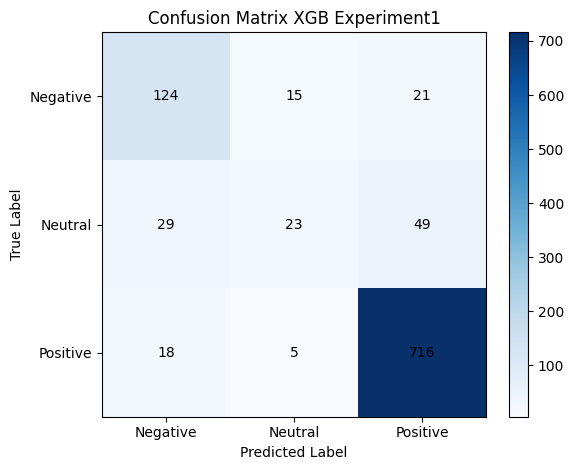

In [27]:
cm = confusion_matrix(test_df["sentiment_id"], test_preds)
labels = ["Negative", "Neutral", "Positive"]

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix XGB Experiment1")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [28]:
joblib.dump(XGB_distilbert_1, "XGB_distilbert_experiment1.pkl")
print("Model saved to XGB_distilbert_experiment1.pkl")

Model saved to XGB_distilbert_experiment1.pkl
